In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
# !pip install tensorflow-gpu==2.0.0-rc1
!pip install 'h5py==2.10.0' --force-reinstall

^C


ERROR: Invalid requirement: "'h5py==2.10.0'": Expected package name at the start of dependency specifier
    'h5py==2.10.0'
    ^


In [41]:
pip install mysql-connector-python

   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ----- ---------------------------------- 2.1/14.3 MB 14.7 MB/s eta 0:00:01
   ------------- -------------------------- 5.0/14.3 MB 14.4 MB/s eta 0:00:01
   ----------------------- ---------------- 8.4/14.3 MB 14.5 MB/s eta 0:00:01
   ------------------------------- -------- 11.3/14.3 MB 14.4 MB/s eta 0:00:01
   ---------------------------------------  14.2/14.3 MB 14.1 MB/s eta 0:00:01
   ---------------------------------------- 14.3/14.3 MB 13.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import mysql.connector
import numpy as np
# 데이터베이스 연결 설정
db_connection = mysql.connector.connect(
    host='localhost',        # MySQL 서버 주소
    user='root',    # MySQL 사용자명
    password='1234', # MySQL 비밀번호
    database='lotto'  # 연결할 데이터베이스 이름
)

# 커서 생성
cursor = db_connection.cursor()

# SQL 쿼리 실행
cursor.execute("SELECT * FROM lotto")

rows = cursor.fetchall()
rows = np.array(rows)
row_count = len(rows)
print(f'총 {row_count}개의 로또 기록이 있습니다.')



총 537개의 로또 기록이 있습니다.


In [4]:
import numpy as np


def numbers2ohbin(numbers):

    ohbin = np.zeros(45) #45개의 빈 칸을 만듬

    for i in range(6): #여섯개의 당첨번호에 대해서 반복함
        ohbin[int(numbers[i])-1] = 1 #로또번호가 1부터 시작하지만 벡터의 인덱스 시작은 0부터 시작하므로 1을 뺌
    
    return ohbin

#원핫인코딩으로 변환
def ohbin2numbers(ohbin):

    numbers = []
    
    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)
    
    return numbers

In [5]:
numbers = rows[:, 1:7]
ohbins = list(map(numbers2ohbin, numbers))

x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1:row_count]

#원핫인코딩으로 표시
print("ohbins")
print("X[0]: " + str(x_samples[0]))
print("Y[0]: " + str(y_samples[0]))

#번호로 표시
print("numbers")
print("X[0]: " + str(ohbin2numbers(x_samples[0])))
print("Y[0]: " + str(ohbin2numbers(y_samples[0])))

ohbins
X[0]: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
numbers
X[0]: [2, 16, 19, 31, 34, 35]
Y[0]: [13, 14, 22, 27, 30, 38]


In [8]:
train_idx = (0, 400) #훈련
val_idx = (401, 500) #검증
test_idx = (501, len(x_samples)) #시험

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델을 정의합니다.
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
print(tf.__version__)

2.13.0


In [13]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states()

    batch_train_loss = []
    batch_train_acc = []
    
    for i in range(train_idx[0], train_idx[1]):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys) #배치만큼 모델에 입력하여 나온 답을 정답과 비교함
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))

epoch    0 train acc 0.037 loss 0.417 val acc 0.051 loss 0.399
epoch    1 train acc 0.040 loss 0.397 val acc 0.051 loss 0.398
epoch    2 train acc 0.037 loss 0.394 val acc 0.051 loss 0.398
epoch    3 train acc 0.043 loss 0.391 val acc 0.030 loss 0.398
epoch    4 train acc 0.043 loss 0.387 val acc 0.020 loss 0.400
epoch    5 train acc 0.050 loss 0.382 val acc 0.010 loss 0.402
epoch    6 train acc 0.055 loss 0.375 val acc 0.020 loss 0.405
epoch    7 train acc 0.060 loss 0.367 val acc 0.020 loss 0.409
epoch    8 train acc 0.060 loss 0.360 val acc 0.020 loss 0.413
epoch    9 train acc 0.080 loss 0.352 val acc 0.020 loss 0.418
epoch   10 train acc 0.080 loss 0.344 val acc 0.020 loss 0.422
epoch   11 train acc 0.077 loss 0.336 val acc 0.010 loss 0.427
epoch   12 train acc 0.092 loss 0.328 val acc 0.010 loss 0.432
epoch   13 train acc 0.102 loss 0.319 val acc 0.010 loss 0.438
epoch   14 train acc 0.113 loss 0.311 val acc 0.010 loss 0.443
epoch   15 train acc 0.115 loss 0.301 val acc 0.010 los

In [27]:

pip install matplotlib

   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.5 MB 4.8 MB/s eta 0:00:02
   ----------- ---------------------------- 2.1/7.5 MB 5.9 MB/s eta 0:00:01
   ------------------- -------------------- 3.7/7.5 MB 6.4 MB/s eta 0:00:01
   ---------------------- ----------------- 4.2/7.5 MB 5.2 MB/s eta 0:00:01
   -------------------------------- ------- 6.0/7.5 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------- 7.5/7.5 MB 6.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------- ----------- 1.8/2.6 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 9.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


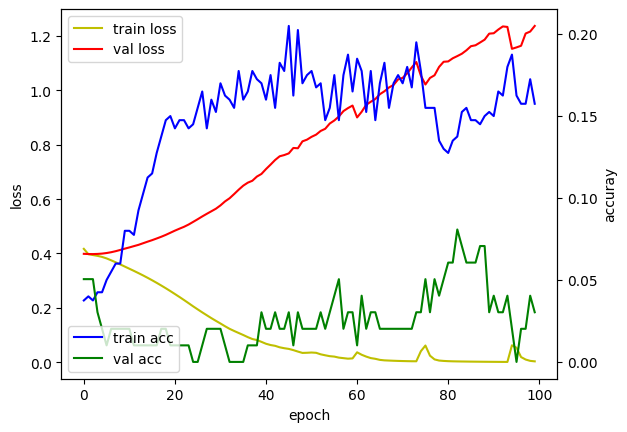

In [14]:
# 그래프로 성능 확인(딥러닝을 학습한다고 해서 검증값은 잘 나오지 않는걸 알 수 있음.)
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [16]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

In [17]:
#검증셋 없이 모든 데이터를 다시 훈련시킨다.
# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(x_samples)):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))


epoch    0 train acc 0.139 loss 0.150
epoch    1 train acc 0.134 loss 0.219
epoch    2 train acc 0.134 loss 0.223
epoch    3 train acc 0.138 loss 0.213
epoch    4 train acc 0.141 loss 0.202
epoch    5 train acc 0.142 loss 0.190
epoch    6 train acc 0.143 loss 0.179
epoch    7 train acc 0.146 loss 0.169
epoch    8 train acc 0.147 loss 0.160
epoch    9 train acc 0.147 loss 0.152
epoch   10 train acc 0.149 loss 0.144
epoch   11 train acc 0.149 loss 0.138
epoch   12 train acc 0.149 loss 0.132
epoch   13 train acc 0.150 loss 0.126
epoch   14 train acc 0.152 loss 0.121
epoch   15 train acc 0.154 loss 0.116
epoch   16 train acc 0.154 loss 0.112
epoch   17 train acc 0.153 loss 0.107
epoch   18 train acc 0.154 loss 0.103
epoch   19 train acc 0.155 loss 0.100
epoch   20 train acc 0.156 loss 0.097
epoch   21 train acc 0.156 loss 0.093
epoch   22 train acc 0.157 loss 0.090
epoch   23 train acc 0.158 loss 0.088
epoch   24 train acc 0.159 loss 0.085
epoch   25 train acc 0.159 loss 0.083
epoch   26 t

In [18]:
# 마지막 회차까지 학습한 모델로 다음 회차 추론

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(10):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n+1, numbers))
    list_numbers.append(numbers)

receive numbers
1 : [2, 3, 5, 7, 11, 37]
2 : [2, 7, 23, 30, 33, 40]
3 : [2, 5, 7, 11, 21, 33]
4 : [2, 7, 11, 17, 21, 33]
5 : [2, 6, 7, 33, 38, 42]
6 : [2, 5, 7, 23, 33, 44]
7 : [2, 3, 7, 25, 33, 38]
8 : [2, 7, 11, 12, 14, 33]
9 : [2, 3, 5, 7, 21, 33]
10 : [2, 3, 7, 11, 25, 33]
